Text(0.5, 1.0, 'Original image')

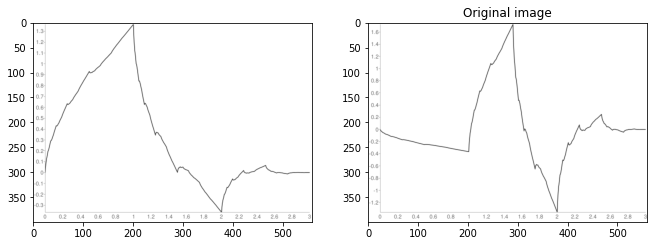

In [2]:
%matplotlib inline
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import pywt
from PIL import Image
from math import sqrt
import sys, getopt
from matplotlib import rcParams
import numpy as np
import scipy.ndimage.filters
from scipy.signal import convolve
import matplotlib.pyplot as plt
import os

url_1 = 'https://i.ibb.co/TkMRC83/chart-1.png'
url_2 = 'https://i.ibb.co/xj3X1rG/chart-2.png'
response_1 = requests.get(url_1)
response_2 = requests.get(url_2)
img_1 = Image.open(BytesIO(response_1.content)).convert('L')
img_2 = Image.open(BytesIO(response_2.content)).convert('L')
output_url = 'https://i.ibb.co/2cHH0s5/Comparision.png'
output_response = requests.get(output_url)
output_image = Image.open(BytesIO(output_response.content)).convert('L')
# display the image
rcParams['figure.figsize'] = 11 ,8
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1, cmap='gray', vmin=0, vmax=255);
ax[1].imshow(img_2, cmap='gray', vmin=0, vmax=255);
plt.title("Original image")


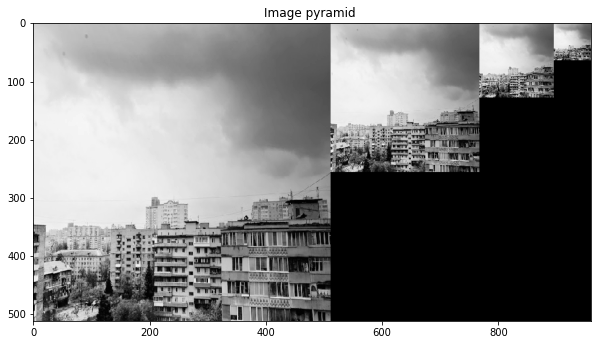

array([[181., 181., 182., ...,  93.,  91.,  90.],
       [182., 182., 182., ...,  92.,  89.,  86.],
       [181., 182., 182., ...,  89.,  86.,  85.],
       ...,
       [176., 180., 110., ...,   0.,   0.,   0.],
       [180., 174., 102., ...,   0.,   0.,   0.],
       [178., 162.,  99., ...,   0.,   0.,   0.]])

In [ ]:
def gaussian_filter(filter_size):
    """ get gaussian filter with filter size"""

    if filter_size == 1:
        return np.array([[1]])

    filter = np.float64(np.array([[1, 1]]))

    for i in range(filter_size - 2):
        filter = scipy.signal.convolve2d(filter, np.array([[1, 1]]))

    return filter / np.sum(filter)


def blur_im(im, filter_vec):
    """ blur an image with filter vector"""
    blur_rows = scipy.ndimage.filters.convolve(im, filter_vec)
    blur_columns = scipy.ndimage.filters.convolve(blur_rows, filter_vec.T)
    return blur_columns


def reduce(im, filter_vec):
    """ reduce an image"""
    blurred_im = blur_im(im, filter_vec)
    return blurred_im[::2, ::2]


def expand(im, filter_vec):
    """ expand an image"""
    # zero padding
    im_shape = im.shape
    expanded_im = np.zeros((2 * im_shape[0], 2 * im_shape[1]))
    expanded_im[::2, ::2] = im
    return blur_im(expanded_im, 2 * filter_vec)


def build_gaussian_pyramid(im, max_levels, filter_size):
    """ functions that construct a Gaussian pyramid of a given image."""

    pyr = []
    filter_vec = gaussian_filter(filter_size)
    next_level_im = im
    max_levels = min(max_levels, int(np.log(im.shape[0] // 16) / np.log(2)) + 1,
                     int(np.log(im.shape[1] // 16) / np.log(2)) + 1)

    for i in range(max_levels):
        pyr.append(next_level_im)
        next_level_im = reduce(np.copy(next_level_im), filter_vec)

    return pyr, filter_vec


def build_laplacian_pyramid(im, max_levels, filter_size):
    """ functions that construct a Laplacian pyramid of a given image."""
    pyr = []
    gaus_pyr, filter_vec = build_gaussian_pyramid(im, max_levels, filter_size)

    for i in range(len(gaus_pyr) - 1):
        Ln = gaus_pyr[i] - expand(np.copy(gaus_pyr[i + 1]), filter_vec)
        pyr.append(Ln)

    pyr.append(gaus_pyr[-1])
    return pyr, filter_vec


def laplacian_to_image(lpyr, filter_vec, coeff):
    """ reconstruction of an image from its Laplacian Pyramid."""
    reconstructed_im = lpyr[-1] * coeff[-1]

    for i in range(len(lpyr) - 2, -1, -1):
        reconstructed_im = lpyr[i] * coeff[i] + expand(reconstructed_im, filter_vec)

    return reconstructed_im

def render_pyramid(pyr, levels):
    """ """
    levels=min(len(pyr),levels)
    new_shape0 = pyr[0].shape[0]
    new_shape1 = int(pyr[0].shape[1] * (1 - np.power(0.5, levels)) / 0.5)
    res = np.zeros((new_shape0, new_shape1))
    start_col = 0
    stretched_im = []

    for level in range(levels):
        #stretched_im.append(stretch_im(np.copy(pyr[level])))
        stretched_im.append(pyr[level])
        cur_level_shape = stretched_im[level].shape
        res[:cur_level_shape[0], start_col:cur_level_shape[1] + start_col] = stretched_im[level]
        start_col += cur_level_shape[1]
    return res


def display_pyramid(pyr, levels):
    """ render and display the stacked pyramid image"""
    res = render_pyramid(pyr, levels)
    figsize = (10,10)
    plt.figure(figsize=figsize)
    plt.imshow(res, cmap='gray')
    plt.title("Image pyramid ")
    plt.show()
    return res

input_url = 'https://github.com/Dubbinary/wavelet_transform/blob/434e3cf3f8a8913bed638182057a36d37c0a3499/res/6.jpg?raw=true'
input_response = requests.get(input_url)
input_image = Image.open(BytesIO(input_response.content)).convert('L')

input_image = np.asarray(input_image)

# build gaussian pyramid 
pyr, filter_vec = build_gaussian_pyramid(input_image, 4, 1)
display_pyramid(pyr, 4)

Text(0.5, 1.0, 'Image compression using the Wavelet function ')

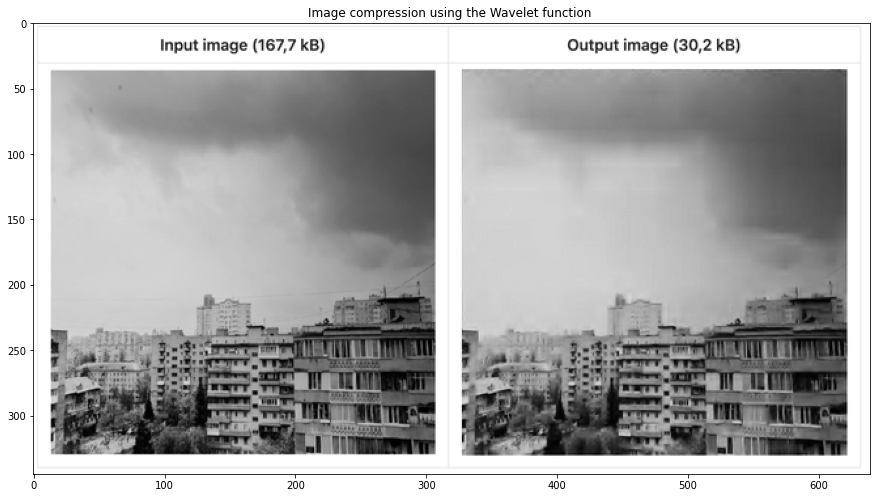

In [ ]:
def encoding_grayscale(image_ch, CL, threshold):
    """
    :param image_ch: Numpy array of image channel
    :param CL: Coefficients of low frequency filter
    :param threshold: threshold: Parameter of quantization [0..1]
    :return: Encoded numpy image array
    """
    image_ch = image_ch / 255
    w, h = image_ch.shape
    while w >= len(CL) and h >= len(CL):
        image_ch[0:w, 0:h] = dwt2(image_ch[0:w, 0:h], CL)
        w = int(w / 2)
        h = int(h / 2)
#    show_image_from_nmlz_data(image_ch, color_mode="F")
    if verbose:
        print("Quantization with parameter: ",
              "\nGRAYSCALE_CHANNEL = "+str(threshold))
    image_ch[abs(image_ch) < threshold] = 0
    #show_image_from_nmlz_data(image_ch, color_mode="F")
    return image_ch

def decode_grayscale(image_ch, CL):
    """
    :param image_ch: Numpy array of encoded image channel (grayscale)
    :param CL: Coefficients of low frequency filter
    :return: Decoded image object
    """
    im_width, im_heigh = image_ch.shape
    w = h = len(CL)
    while w <= im_width and h <= im_heigh:
        image_ch[0:w, 0:h] = idwt2(image_ch[0:w, 0:h], CL)
        w *= 2
        h *= 2
    decoded_img = Image.fromarray(image_ch * 255, "F")
    return decoded_img


def idwt2(data, CL):
    """
    :param data: two-dimensional transformed image
    :param CL: Coefficients of low frequency filter
    :return: Return two-dimensional backward transformation of image
    """
    w, h = data.shape
    # Rearrange the columns and rows back
    imageT = data.copy()
    imageT[0:h:2, 0:w:2] = data[0:int(h/2), 0:int(w/2)]
    imageT[1:h:2, 0:w:2] = data[int(h/2):h, 0:int(w/2)]
    imageT[0:h:2, 1:w:2] = data[0:int(h/2), int(w/2):w]
    imageT[1:h:2, 1:w:2] = data[int(h/2):h, int(w/2):w]
    CH = get_hpf_coeffs(CL)
    iCL, iCH = get_icoeffs(CL, CH)
    image = imageT.copy()               # Copy the original image to convert
    for i in range(w):                  # Process the columns
        image[:, i] = pconv(image[:, i], iCL, iCH, delta=len(iCL)-2)
    for i in range(h):                  # Process the lines
        image[i, :] = pconv(image[i, :], iCL, iCH, delta=len(iCL)-2)
    return image

def dwt2(image, CL):
    """
    :param image: two-dimensional array representation of image
    :param CL: Coefficients of low frequency filter
    :return: Return two-dimensional transformation of image
    """
    CH = get_hpf_coeffs(CL)     # Calculate the missing coefficients
    w, h = image.shape
    imageT = image.copy()       # Copy the original image to convert ######################
    for i in range(h):          # Process the lines
        imageT[i, :] = pconv(imageT[i, :], CL, CH)
    for i in range(w):          # Process the columns
        imageT[:, i] = pconv(imageT[:, i], CL, CH)
    # Rearrange the columns and rows isolating filters
    data = imageT.copy()
    data[0:int(h / 2), 0:int(w / 2)] = imageT[0:h:2, 0:w:2]   # top-left
    data[int(h / 2):h, 0:int(w / 2)] = imageT[1:h:2, 0:w:2]   # bottom-left
    data[0:int(h / 2), int(w / 2):w] = imageT[0:h:2, 1:w:2]   # top-right
    data[int(h / 2):h, int(w / 2):w] = imageT[1:h:2, 1:w:2]   # bottom-right
    return data

def get_hpf_coeffs(CL):            # Coefficients of high frequency filter
    """
    :param CL: Coefficients of low frequency filter
    :return: Return list with coefficients of high frequency filter
    """
    N = len(CL)                    # The number of coefficients
    CH = [(-1)**k * CL[N - k - 1]  # The coefficients in reverse order with alternating sign
        for k in range(N)]
    return CH


def pconv(data, CL, CH, delta = 0):
    """
    :param data: Data on which performed transformation
    :param CL: Coefficients of low frequency filter
    :param CH: Coefficients of high frequency filter
    :param delta: Parameter which provide shift of coefficients
    :return: Return transformed data
    """
    assert(len(CL) == len(CH))          # Dimensions lists factors should be equal
    N = len(CL)
    M = len(data)
    out = []                            # List a result, until empty
    for k in range(0, M, 2):            # Loop through the numbers 0, 2, 4 ...
        sL = 0                          # Low-frequency coefficient
        sH = 0                          # High-frequency coefficient
        for i in range(N):              # We find ourselves weighted sums
            sL += data[(k + i - delta) % M] * CL[i]
            sH += data[(k + i - delta) % M] * CH[i]
        out.append(sL)
        out.append(sH)
    return out

def get_icoeffs(CL, CH):
    """
    :param CL: Coefficients of low frequency filter
    :param CH: Coefficients of high frequency filter
    :return: Return coefficients that used in backward transformation
    """
    assert(len(CL) == len(CH))          # Dimensions lists factors should be equal
    iCL = []                            # The coefficients of the first line
    iCH = []                            # The coefficients of the second line
    for k in range(0, len(CL), 2):
        iCL.extend([CL[k-2], CH[k-2]])
        iCH.extend([CL[k-1], CH[k-1]])
    return (iCL, iCH)

# display the output
figsize = (15,15)
plt.figure(figsize=figsize)

plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)
plt.title("Image compression using the Wavelet function ")